# Q1

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
airports_df = pd.read_csv(f"{path}/Airports2.csv")
print(airports_df.info())
print(airports_df.describe())
print(airports_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB
None
         Passengers         Seats       Flights      Distance  \
count  3.606803e+06  3.606803e+06  3.606803e+06  3.606803e+06   
mean   2.688910e+03  4.048297e+03  3.722890e+01  6.973190e+

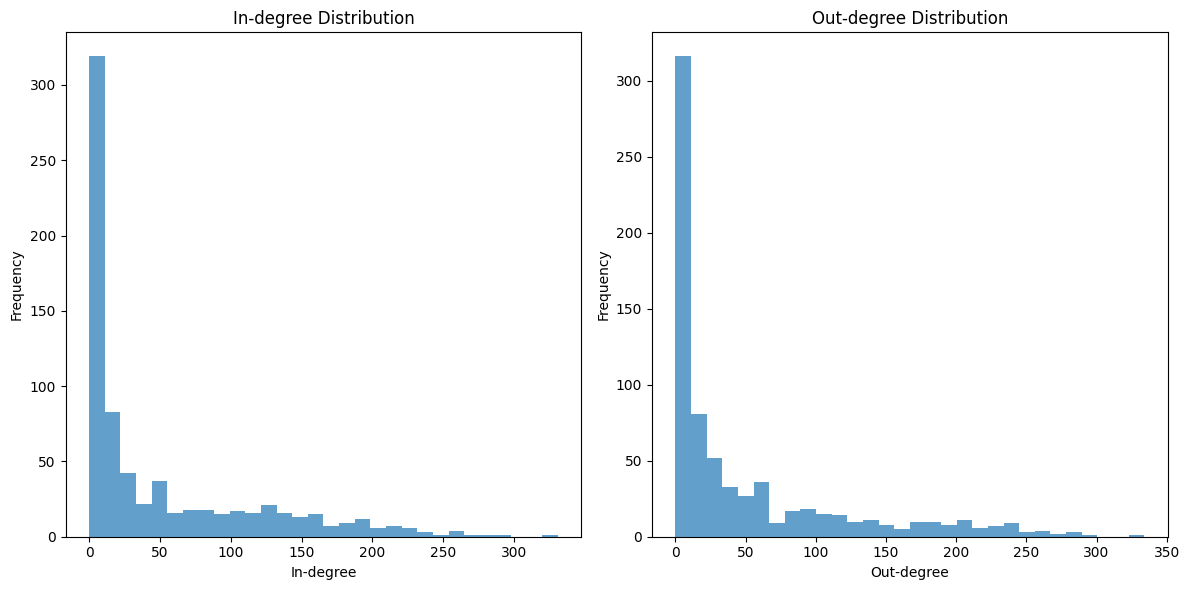

Hubs identified: ['BDL', 'ATL', 'BHM', 'BNA', 'BOS', 'BUF', 'BWI', 'CAE', 'CLE', 'CLT', 'CMH', 'CVG', 'DAY', 'DSM', 'DTW', 'EWR', 'FLL', 'FWA', 'GRR', 'GSO', 'GSP', 'IAD', 'ICT', 'IND', 'JAX', 'JFK', 'LAS', 'LAX', 'LEX', 'LGA', 'LIT', 'MCI', 'MCO', 'MDW', 'MEM', 'MIA', 'MKE', 'MSN', 'MSP', 'MSY', 'OKC', 'OMA', 'ORD', 'PHL', 'PIT', 'RDU', 'RFD', 'SLC', 'STL', 'TOL', 'TPA', 'TYS', 'ABQ', 'AUS', 'DAL', 'DFW', 'ELP', 'HOU', 'IAH', 'LRD', 'PHX', 'RNO', 'SAN', 'SAT', 'SHV', 'TUS', 'COS', 'OAK', 'PDX', 'SEA', 'SFO', 'TUL', 'YIP']


Summary of Graph Features:
{'Number of Nodes': 727, 'Number of Edges': 36719, 'Density': 0.1391392984490396, 'Graph Type': 'dense', 'Hubs': ['BDL', 'ATL', 'BHM', 'BNA', 'BOS', 'BUF', 'BWI', 'CAE', 'CLE', 'CLT', 'CMH', 'CVG', 'DAY', 'DSM', 'DTW', 'EWR', 'FLL', 'FWA', 'GRR', 'GSO', 'GSP', 'IAD', 'ICT', 'IND', 'JAX', 'JFK', 'LAS', 'LAX', 'LEX', 'LGA', 'LIT', 'MCI', 'MCO', 'MDW', 'MEM', 'MIA', 'MKE', 'MSN', 'MSP', 'MSY', 'OKC', 'OMA', 'ORD', 'PHL', 'PIT', 'RDU', 'RFD', 'SLC', 'STL', 'TOL', 'TPA', 'TYS', 'ABQ', 'AUS', 'DAL', 'DFW', 'ELP', 'HOU', 'IAH', 'LRD', 'PHX', 'RNO', 'SAN', 'SAT', 'SHV', 'TUS', 'COS', 'OAK', 'PDX', 'SEA', 'SFO', 'TUL', 'YIP']}

Busiest Routes by Traffic:
           Origin_city Destination_city  Passengers
7122        Dallas, TX      Houston, TX    38295025
12391      Houston, TX       Dallas, TX    37989016
13585      Kahului, HI     Honolulu, HI    32364664
12259     Honolulu, HI      Kahului, HI    29744742
16133  Los Angeles, CA     Honolulu, HI    28964232
12264  

In [ ]:
# Function to create a flight network graph from the dataset
def create_flight_network(data):
    G = nx.DiGraph()  # Directed graph because flights have direction (origin to destination)

    # Aggregate passengers by (origin, destination)
    aggregated_data = data.groupby(['Origin_airport', 'Destination_airport'], as_index=False)['Passengers'].sum()

    for _, row in aggregated_data.iterrows():
        origin = row['Origin_airport']
        destination = row['Destination_airport']
        passengers = row['Passengers']

        # Add edge with passengers as weight
        G.add_edge(origin, destination, weight=passengers)

    return G, aggregated_data

# Function to analyze the basic graph features
def analyze_graph_features(flight_network):
    num_nodes = len(flight_network.nodes)
    num_edges = len(flight_network.edges)

    # Graph density
    density = 2 * num_edges / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0

    # Efficient In-degree and Out-degree calculation using pandas
    in_degrees = pd.Series([flight_network.in_degree(node) for node in flight_network.nodes], index=flight_network.nodes)
    out_degrees = pd.Series([flight_network.out_degree(node) for node in flight_network.nodes], index=flight_network.nodes)

    # Identify hubs (90th percentile degree)
    all_degrees = in_degrees + out_degrees
    percentile_90 = np.percentile(all_degrees, 90)
    hubs = all_degrees[all_degrees > percentile_90].index.tolist()

    # Sparse or Dense?
    graph_type = "dense" if density >= 0.01 else "sparse"

    # Return analysis data
    return {
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'density': density,
        'in_degrees': in_degrees,
        'out_degrees': out_degrees,
        'hubs': hubs,
        'graph_type': graph_type
    }

# Function to generate a summary report
def summarize_graph_features(flight_network):
    analysis_results = analyze_graph_features(flight_network)

    # Create a summary report
    summary_report = {
        "Number of Nodes": analysis_results['num_nodes'],
        "Number of Edges": analysis_results['num_edges'],
        "Density": analysis_results['density'],
        "Graph Type": analysis_results['graph_type'],
        "Hubs": analysis_results['hubs']
    }

    # Plot histograms for in-degree and out-degree (limited number of bins to improve speed)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(analysis_results['in_degrees'], bins=30, alpha=0.7, label='In-degree')
    plt.xlabel('In-degree')
    plt.ylabel('Frequency')
    plt.title('In-degree Distribution')

    plt.subplot(1, 2, 2)
    plt.hist(analysis_results['out_degrees'], bins=30, alpha=0.7, label='Out-degree')
    plt.xlabel('Out-degree')
    plt.ylabel('Frequency')
    plt.title('Out-degree Distribution')

    plt.tight_layout()
    plt.show()

    print("Hubs identified:", analysis_results['hubs'])

    # Return the summary report
    return summary_report

# Efficient computation of passenger flow
def compute_passenger_flow(data):
    passenger_flow = data.groupby(['Origin_city', 'Destination_city'])['Passengers'].sum().reset_index()
    return passenger_flow

# Efficiently identify the busiest routes by passenger traffic
def busiest_routes_by_traffic(data):
    passenger_flow = compute_passenger_flow(data)
    busiest_routes = passenger_flow.sort_values(by='Passengers', ascending=False).head(10)
    return busiest_routes

# Calculate the average passengers per flight for each route
def route_efficiency(data):
    avg_passengers = data.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].mean().reset_index()
    return avg_passengers

# Highlight under-utilized and over-utilized routes
def highlight_utilized_routes(data, avg_passengers):
    total_passengers = data.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].sum().reset_index()
    total_passengers = total_passengers.merge(avg_passengers, on=['Origin_airport', 'Destination_airport'], suffixes=('_total', '_avg'))

    total_passengers['utilization'] = total_passengers['Passengers_total'] / total_passengers['Passengers_avg']
    under_utilized = total_passengers[total_passengers['utilization'] < 1]
    over_utilized = total_passengers[total_passengers['utilization'] > 1]

    return under_utilized, over_utilized

# Optimized interactive map to visualize flight routes (limit routes to top 50)
def plot_interactive_map(data, flight_network):
    locations = data[['Origin_airport', 'Origin_city', 'Org_airport_lat', 'Org_airport_long']].drop_duplicates()
    locations = locations.rename(columns={'Org_airport_lat': 'Latitude', 'Org_airport_long': 'Longitude'})

    fig = px.scatter_geo(locations, lat='Latitude', lon='Longitude', hover_name='Origin_city', title='Airports in the Flight Network')

    # Add a limited number of flight routes (top 50)
    count = 0
    for u, v in flight_network.edges:
        if count >= 50:  # Limit to top 50 routes
            break
        origin = data[data['Origin_airport'] == u].iloc[0]
        destination = data[data['Destination_airport'] == v].iloc[0]
        fig.add_trace(go.Scattergeo(
            lon=[origin['Org_airport_long'], destination['Dest_airport_long']],
            lat=[origin['Org_airport_lat'], destination['Dest_airport_lat']],
            mode='lines',
            line=dict(width=1, color='blue'),
            opacity=0.5
        ))
        count += 1

    fig.update_geos(projection_type="mercator")
    fig.update_layout(showlegend=False)
    fig.show()

# Load your dataset (Airports2)
airports2 = pd.read_csv(f"{path}/Airports2.csv")

# Create flight network
flight_network, aggregated_data = create_flight_network(airports2)

# Analyze graph features
summary = summarize_graph_features(flight_network)

# Analyze busiest routes
busiest_routes = busiest_routes_by_traffic(airports2)

# Calculate route efficiency
avg_passengers = route_efficiency(airports2)

# Highlight under/over-utilized routes
under_utilized, over_utilized = highlight_utilized_routes(airports2, avg_passengers)

# Visualize the interactive map of flight network
plot_interactive_map(airports2, flight_network)

# Print results
print("Summary of Graph Features:")
print(summary)
print("\nBusiest Routes by Traffic:")
print(busiest_routes)
print("\nUnder-utilized Routes:")
print(under_utilized)
print("\nOver-utilized Routes:")
print(over_utilized)


# Q 2.1

In [ ]:
#function that computes the following centrality measures for a given airport:
def analyze_centrality(flight_network, airport):

    betweenness = nx.betweenness_centrality(flight_network, normalized=True, weight='weight')

    closeness = nx.closeness_centrality(flight_network, distance='weight')

    degree = flight_network.degree(airport, weight='weight')

    pagerank = nx.pagerank(flight_network, weight='weight')

    #results for the given airport
    centrality_results = {
        'Airport': airport,
        'Betweenness Centrality': betweenness.get(airport, 0),
        'Closeness Centrality': closeness.get(airport, 0),
        'Degree Centrality': degree,
        'PageRank': pagerank.get(airport, 0)
    }

    return centrality_results

results = analyze_centrality(flight_network, 'JFK')
print(results)


{'Airport': 'JFK', 'Betweenness Centrality': 3.8217158502439397e+65, 'Closeness Centrality': 0.018087814480641836, 'Degree Centrality': 280781960, 'PageRank': 0.010402095296131958}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Q 2.2

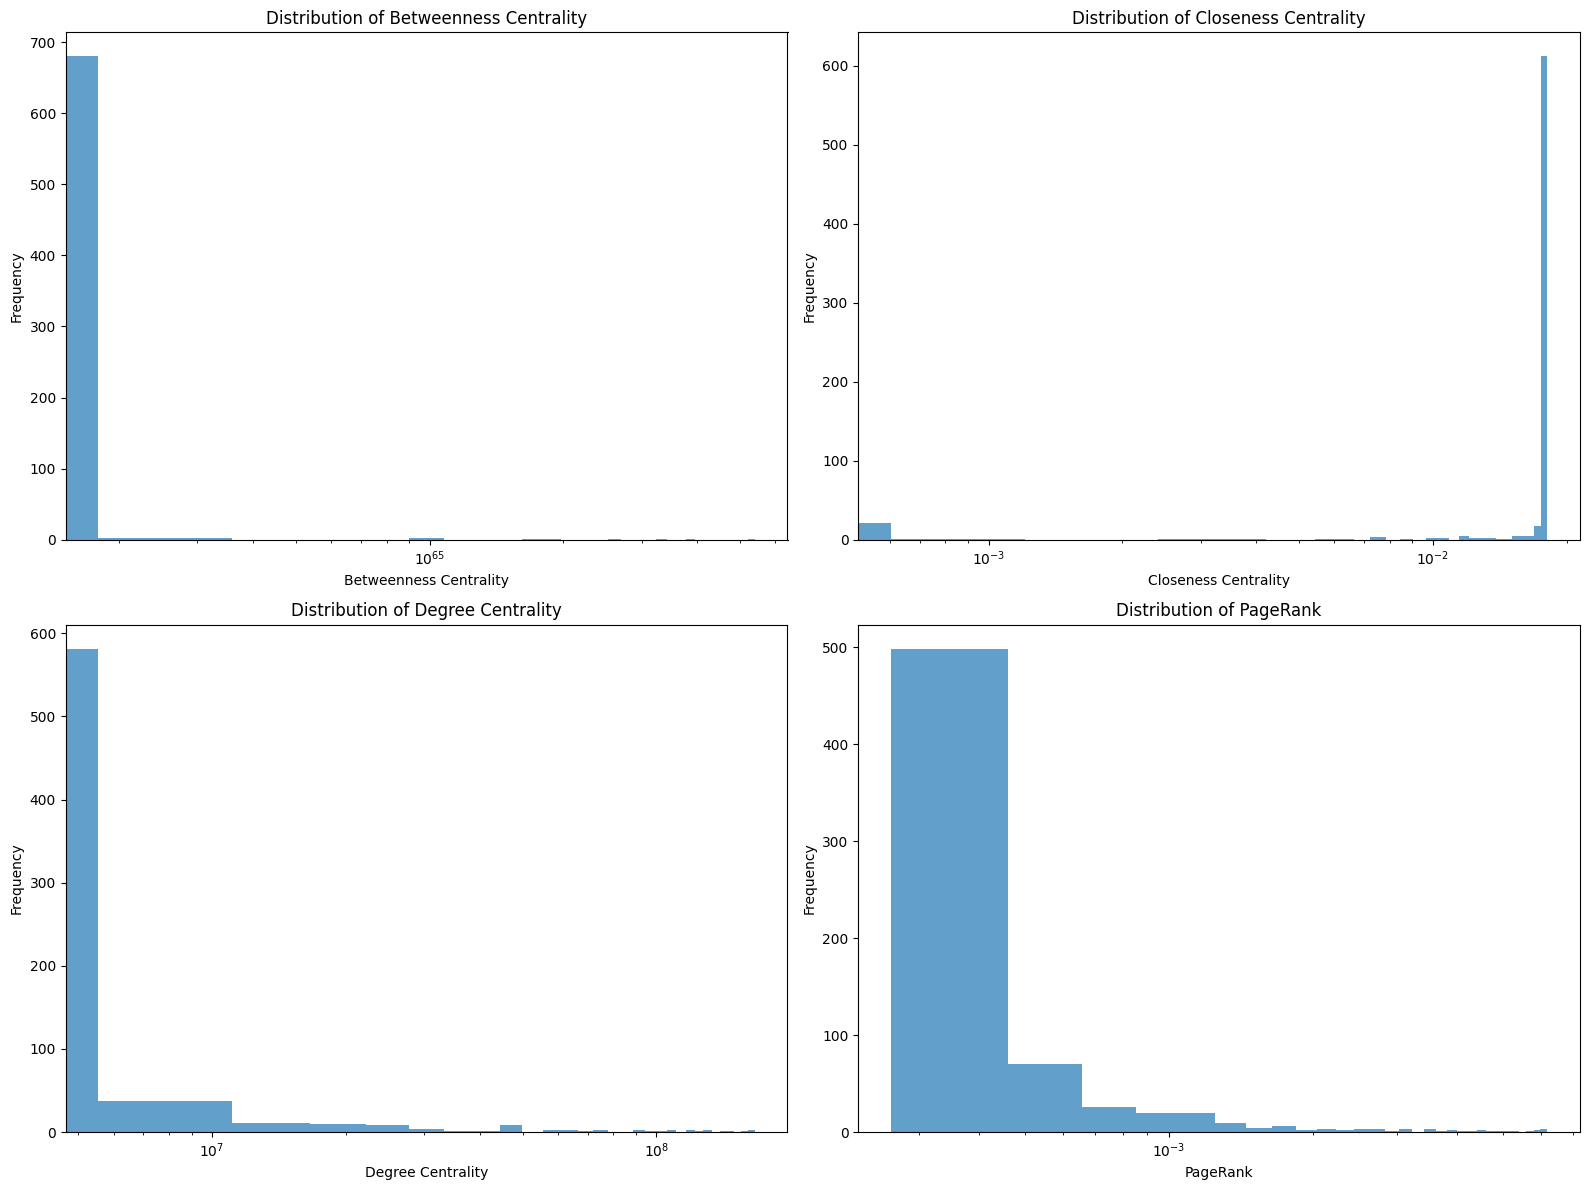

Top 5 airports by Betweenness Centrality:
['OMA', 'ATL', 'MKE', 'STL', 'YIP']

Top 5 airports by Closeness Centrality:
['BYI', 'TDW', 'STE', 'HUA', 'SME']

Top 5 airports by Degree Centrality:
['ATL', 'ORD', 'DFW', 'LAX', 'PHX']

Top 5 airports by PageRank:
['ATL', 'ORD', 'DFW', 'LAX', 'MSP']



In [ ]:
'''
function to
* Compute and compare centrality values for all nodes in the graph.
* Plot centrality distributions (histograms for each centrality measure).
* Return the top 5 airports for each centrality measure.
'''
def compare_centralities(flight_network):

    #centralities for all nodes
    betweenness = nx.betweenness_centrality(flight_network, normalized=True, weight='weight')
    closeness = nx.closeness_centrality(flight_network, distance='weight')
    degree = dict(flight_network.degree(weight='weight'))
    pagerank = nx.pagerank(flight_network, weight='weight')

    #combine centralities into DataFrame
    centralities_df = pd.DataFrame({
        'Betweenness Centrality': betweenness,
        'Closeness Centrality': closeness,
        'Degree Centrality': degree,
        'PageRank': pagerank
    })

    plt.figure(figsize=(16, 12))
    for i, metric in enumerate(centralities_df.columns):
        plt.subplot(2, 2, i + 1)
        data = centralities_df[metric]

        data_without_outliers = data[data < np.percentile(data, 95)]

        plt.hist(data_without_outliers, bins=30, alpha=0.7)
        plt.title(f'Distribution of {metric}')
        plt.xlabel(f'{metric}')
        plt.ylabel('Frequency')
        plt.xscale('log')  #log scale for better visualization
    plt.tight_layout()
    plt.show()

    #top 5 nodes
    top_5_airports = {
        metric: centralities_df[metric].nlargest(5).index.tolist()
        for metric in centralities_df.columns
    }

    return top_5_airports

top_5 = compare_centralities(flight_network)

for centrality, airports in top_5.items():
    print(f"Top 5 airports by {centrality}:")
    print(airports)
    print()


### **Summary of Results**

- **Betweenness Centrality**:
  - High values for OMA, MKE, and STL indicate their importance in connecting regions.
  - ATL is a major global hub, consistently appearing in top rankings.

- **Closeness Centrality**:
  - Airports like BYI and TDW rank high due to their proximity to other nodes in the network, emphasizing their local importance.

- **Degree Centrality**:
  - Top hubs (ATL, ORD, DFW) dominate due to their high number of connections, reflecting their global role in the flight network.

- **PageRank**:
  - Similar to Degree Centrality, highlighting key hubs like ATL, ORD, and LAX with additional weight on their importance.


- The network is highly centralized with a few key nodes (ATL, ORD, DFW) controlling most connectivity.
- Local hubs (OMA, BYI) play critical roles in regional connectivity.
- High Betweenness airports are crucial for maintaining overall network flow.


# Q 2.3

### Alternative Centrality Measures for Analysis

1. **Harmonic Centrality**  
   - Accounts for inverse distances and works well in weakly connected graphs.  
   - Provides non-zero values for nodes in disconnected components.

2. **Eigenvector Centrality**  
   - Measures the influence of a node based on the importance of its neighbors.  
   - Suitable for detecting globally important hubs.  

3. **Katz Centrality**  
   - Extends eigenvector centrality by giving all nodes a base-level importance.  
   - Useful for weakly connected or directed graphs.

4. **Percolation Centrality**  
   - Tracks the impact of a node in spreading information through a network.  
   - Relevant for dynamic or communication-based networks.

5. **Load Centrality**  
   - Similar to betweenness centrality but considers flow-based measures.  
   - Useful for analyzing congestion or capacity in networks.

6. **Clustering Coefficient**  
   - Measures the tendency of nodes to form tightly-knit groups.  
   - Indicates local connectivity patterns around nodes.

### Verifying the Results
To ensure the trustability of the results:
- Compare new metrics with existing ones like Degree Centrality or Betweenness Centrality.
- Check the consistency of top-ranked nodes across different centrality measures.
- Visualize and analyze the distributions of the new metrics to identify outliers or anomalies.


# Q 2.4

In [ ]:
#сheck strong and weak connectivity
if nx.is_strongly_connected(flight_network):
    print("The graph is strongly connected.")
elif nx.is_weakly_connected(flight_network):
    print("The graph is weakly connected.")
else:
    print("The graph is disconnected.")


The graph is weakly connected.


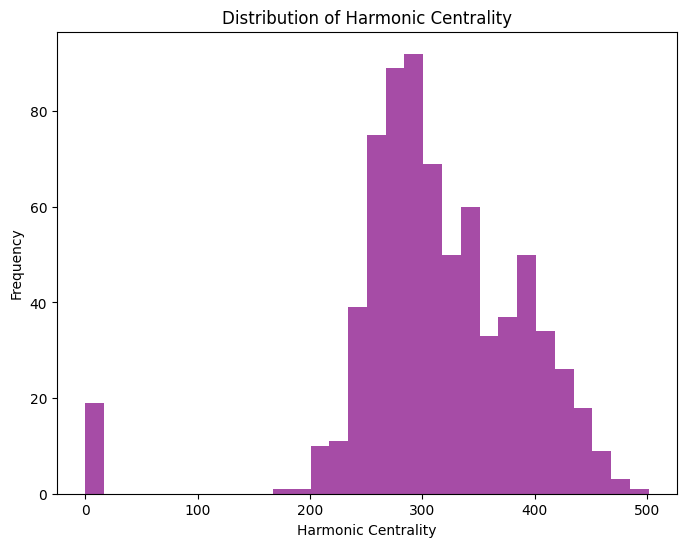

Top 5 airports by Harmonic Centrality: ['YIP', 'MSP', 'MEM', 'MCI', 'STL']


In [ ]:
#сalculate Harmonic Centrality
harmonic_centrality = nx.harmonic_centrality(flight_network)

harmonic_df = pd.DataFrame.from_dict(harmonic_centrality, orient='index', columns=['Harmonic Centrality'])

#distribution of Harmonic Centrality
plt.figure(figsize=(8, 6))
plt.hist(harmonic_df['Harmonic Centrality'], bins=30, alpha=0.7, color='purple')
plt.title('Distribution of Harmonic Centrality')
plt.xlabel('Harmonic Centrality')
plt.ylabel('Frequency')
plt.show()

#top 5 nodes by Harmonic Centrality
top_5_harmonic = harmonic_df['Harmonic Centrality'].nlargest(5).index.tolist()
print("Top 5 airports by Harmonic Centrality:", top_5_harmonic)


### Comparison of Closeness Centrality and Harmonic Centrality

**Closeness Centrality**
- Most values are concentrated around 10^(-2), with many nodes having near-zero centrality <10^(-3).
- Nodes in disconnected components are assigned a centrality of 0.
- Not suitable for weakly connected graphs.

**Harmonic Centrality**
- Values are distributed over a wider range (200–400), providing meaningful results even for isolated nodes.
- Compensates for the lack of direct paths by considering inverse distances.

**Conclusion**
- **Harmonic Centrality** is more reliable for weakly connected graphs, capturing both local and global accessibility.
- **Closeness Centrality** should only be used for strongly connected components.


# Q3

We check that there are no empty values in the Distance column for correct graph construction.

In [ ]:
missing_values = airports2.isnull().sum()
print(missing_values)

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64


In [ ]:
from IPython.display import display

def create_graph_from_dataframe(df):
    """
    Create a directed graph from a DataFrame with edges weighted by distance.
    """
    G = nx.DiGraph()
    for _, row in df.iterrows():
        if not pd.isnull(row['Distance']):
            G.add_edge(
                row['Origin_airport'],
                row['Destination_airport'],
                weight=row['Distance']
            )
    return G


def find_best_routes(flight_network_df, origin_city, destination_city, fly_date):
    """
    Find the best routes (shortest by distance) between airports in two cities for a given date.
    """
    filtered_data = flight_network_df[flight_network_df['Fly_date'] == fly_date]

    G = create_graph_from_dataframe(filtered_data)

    origin_airports = filtered_data[filtered_data['Origin_city'] == origin_city]['Origin_airport'].unique()
    destination_airports = filtered_data[filtered_data['Destination_city'] == destination_city]['Destination_airport'].unique()

    best_routes = []

    for origin in origin_airports:
        for destination in destination_airports:
            try:
                path = nx.shortest_path(G, source=origin, target=destination, weight='weight')
                best_routes.append({
                    'Origin_city_airport': origin,
                    'Destination_city_airport': destination,
                    'Best_route': ' → '.join(path)
                })
            except nx.NetworkXNoPath:
                best_routes.append({
                    'Origin_city_airport': origin,
                    'Destination_city_airport': destination,
                    'Best_route': 'No route found'
                })

    return pd.DataFrame(best_routes)

best_route_df = find_best_routes(airports2, 'Seattle, WA', 'Bend, OR', '1990-02-01')

from IPython.display import display
display(best_route_df)


Origin_city_airport Destination_city_airport       Best_route
0                 SEA                      RDM        SEA → RDM
1                 BFI                      RDM  BFI → SEA → RDM

In [ ]:
#trying more examples

examples = [
    {'origin_city': 'Eugene, OR', 'destination_city': 'Bend, OR', 'fly_date': '1990-11-01'},
    {'origin_city': 'Medford, OR', 'destination_city': 'Bend, OR', 'fly_date': '1990-02-01'},
    {'origin_city': 'Seattle, WA', 'destination_city': 'Bend, OR', 'fly_date': '1990-02-01'},
    {'origin_city': 'Manhattan, KS', 'destination_city': 'Ames, IA', 'fly_date': '2008-10-01'},
]


all_results = pd.DataFrame()

for example in examples:
    result = find_best_routes(
        flight_network_df=airports2,
        origin_city=example['origin_city'],
        destination_city=example['destination_city'],
        fly_date=example['fly_date']
    )
    all_results = pd.concat([all_results, result], ignore_index=True)



display(all_results)


Origin_city_airport Destination_city_airport       Best_route
0                 EUG                      RDM        EUG → RDM
1                 MFR                      RDM        MFR → RDM
2                 SEA                      RDM        SEA → RDM
3                 BFI                      RDM  BFI → SEA → RDM
4                 MHK                      AMW        MHK → AMW

# **(Q4)** - Airline Network Partitioning

To solve the graph disconnection, we can use some different algorithms to find the min. number of edges (flights) that we have to remove to split the flight network into two separate and disconnected parts. This is similar to the min-cut problem, which can be described as: <br>

**Input**: An undirected and unweighted graph ${\displaystyle G=(V,E)}$ <br>
**Output**: Compute a cut with the fewest number of edges that separates the graph into two disconnected components. <br>

To approach the problem we are using the **Stoer-Wagner Minimum Cut Algorithm**.


**Stoer-Wagner Minimum Cut Algorithm:**

For the problem of graph disconnection, the Stoer-Wagner algorithm provides a deterministic approach to finding the minimum cut in an undirected graph. This algorithm solves:

**Input**: An undirected graph $G=(V,E)$ with non-negative edge weights  
**Output**: A minimum cut that separates the graph into two disconnected components

---

**MinimumCutPhase (G, w, a)**
*   $A \gets \{a\}$ # initialise a set A with an arbitrary vertex a
*   while $A \neq V$: # for all the vertices different from A
 *   Add to $A$ the most tightly connected vertex.
*   Store the cut in which the last remaining vertex is by itself (the "cut-of-the-phase").
*   Shrink $G$ by merging the two vertices $(s, t)$ added last (the value of "cut-of-the-phase" is the value of minimum $s, t$ cut).

**MinimumCut (G, w, a)**
*   while $|V| > 1$:
    *   MinimumCutPhase(G, w, a)
    *   if the cut-of-the-phase is lighter than the current minimum cut:
        *   Store the cut-of-the-phase as the current minimum cut.

In [ ]:
# Load the data!
flight_df = pd.read_csv('Airports2.csv')
flight_df.drop_duplicates(keep='last', inplace=True)
working_df = flight_df[['Origin_airport', 'Destination_airport']].copy()

In [ ]:
help(shortest_path.create_undirected_flight_network)

Help on function create_undirected_flight_network in module shortest_path:

create_undirected_flight_network(working_df)
    Creates an undirected graph from flight data with edge cost of 1.

    Args:
        working_df (pd.DataFrame): DataFrame with Origin_airport and Destination_airport columns
    Returns:
        nx.Graph: Undirected graph with weighted edges - cost of 1



In [ ]:
help(shortest_path.visualize_network)

Help on function visualize_network in module shortest_path:

visualize_network(G, title, partition=None, fig_size=(12, 8))
    Visualizes the flight network.

    Args:
        G (nx.Graph): The flight network
        title (str): Plot title
        partition (list, optional): List of nodes in one partition
        fig_size (tuple, optional): Figure size



100%|██████████| 3565050/3565050 [00:02<00:00, 1291984.45it/s]


Plotting the undirected flight network


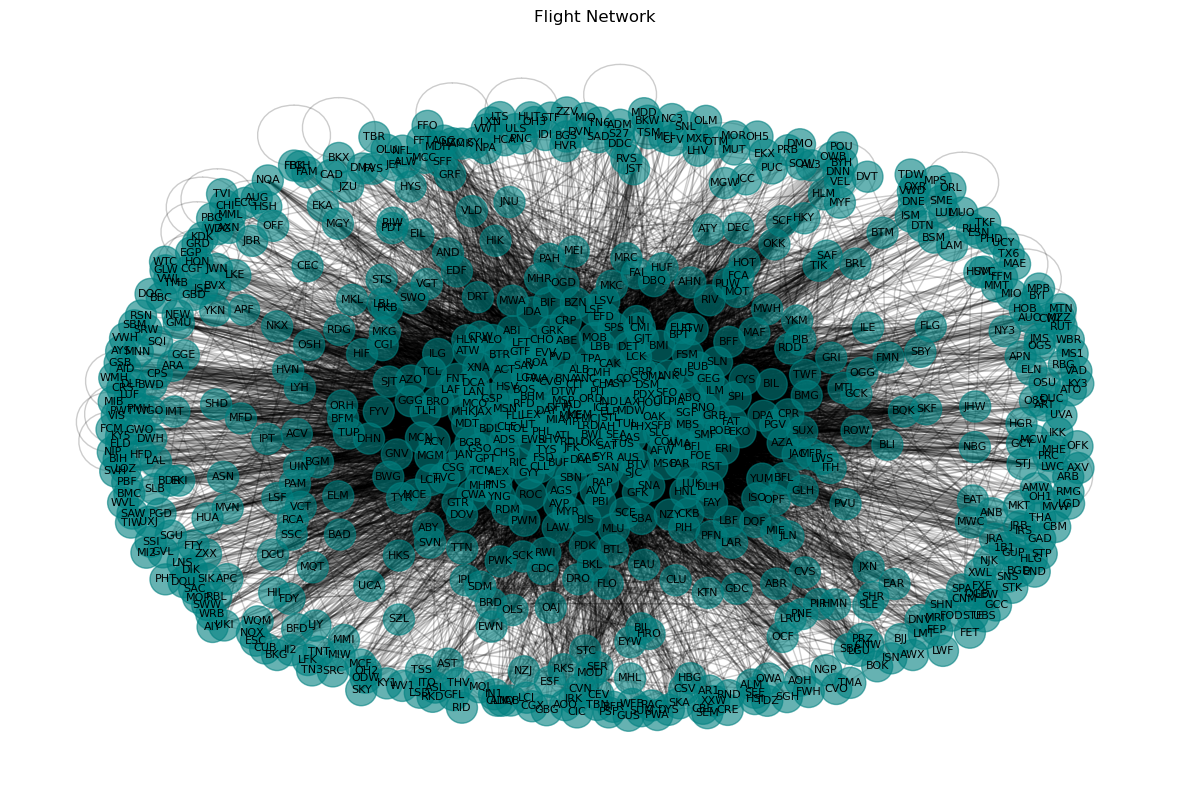

In [ ]:
flight_network_undirected = shortest_path.create_undirected_flight_network(working_df)
print("Plotting the undirected flight network")
# visualize the undirected graph
shortest_path.visualize_network(flight_network_undirected, 'Flight Network')

Now, we are going to:
 * Find the min-cut through the Stoer-Wagner algorithm;
 * Find the edges crossing the cut;
 * Print the edges and their quantity;
 * Displaying the graph having those edges removed.

In [ ]:
help(shortest_path.stoer_wagner_min_cut)

Help on function stoer_wagner_min_cut in module shortest_path:

stoer_wagner_min_cut(G)
    Computes the minimum cut using Stoer-Wagner algorithm. It makes use of the following helper functions:
    - minimum_cut_phase: Implements one phase of the Stoer-Wagner algorithm.
    - merge_vertices: Merges vertex v into vertex u.

    Args:
        G (nx.Graph): The input graph
    Returns:
        tuple: (min_cut_value, partition)
            min_cut_value: The minimum cut value - an int
            partition: The partition with the minimum cut - a list of nodes in one partition



In [ ]:
help(shortest_path.get_cut_edges)

Help on function get_cut_edges in module shortest_path:

get_cut_edges(G, partition)
    Finds edges crossing the cut.

    Args:
        G (nx.Graph): The input graph
        partition (list): List of nodes in one partition
    Returns:
        list: Edges crossing the cut



In [ ]:
min_cut_value, min_cut_partition = shortest_path.stoer_wagner_min_cut(flight_network_undirected)

# Find the edges crossing the cut, that is, the edges connecting the two partitions
cut_edges = shortest_path.get_cut_edges(flight_network_undirected, min_cut_partition)

# Explicity print the number of edges crossing the cut and also the edges crossing the cut
print(f"Number of edges crossing the cut / Min. number of flights to remove: {len(cut_edges)}")
print("Edges crossing the cut:")
for u,v in cut_edges:
    print(f"{u} <-> {v}")

# Make a copy of the original graph so that we can remove the cut edges and then plot the graph
G_copy = flight_network_undirected.copy()

# Remove the cut edges
G_copy.remove_edges_from(cut_edges)

print("Plotting the flight network with the cut edges removed")
# Visualize the graph with the cut edges removed
shortest_path.visualize_network(G_copy, 'Flight Network with Minimum Cut', min_cut_partition)

NameError: name 'shortest_path' is not defined

Now, we'll use the `disconnect_graph` function that takes an undirected graph as input and the edges (flights) removed as output.

In [ ]:
help(shortest_path.disconnect_graph)

Help on function disconnect_graph in module shortest_path:

disconnect_graph(G)
    Disconnects the graph into two separate components by removing a minimum number of flights. Makes use of the following helper functions:
    - stoer_wagner_min_cut: Computes the minimum cut using Stoer-Wagner algorithm.
    - get_cut_edges: Finds edges crossing the cut.
    - visualize_network: Visualizes the flight network.

    Args:
        G (nx.Graph): An undirected graph containing flight data
    Returns:
        cut_edges: A list of edges that, if removed, would disconnect the graph into two separate components.



Visualizing original network...


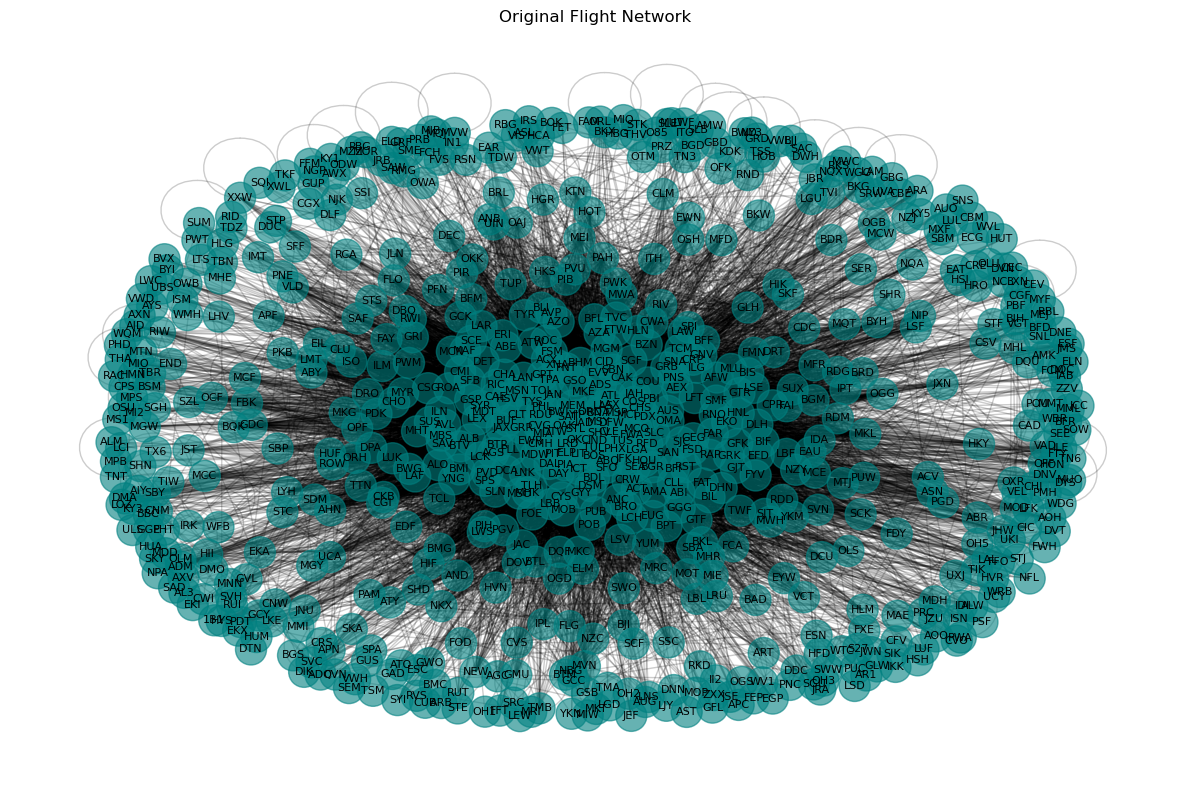

Finding minimum cut...

Minimum number of flights to remove: 1

Flights to remove:
YIP <-> PHD

Visualizing partitioned network...


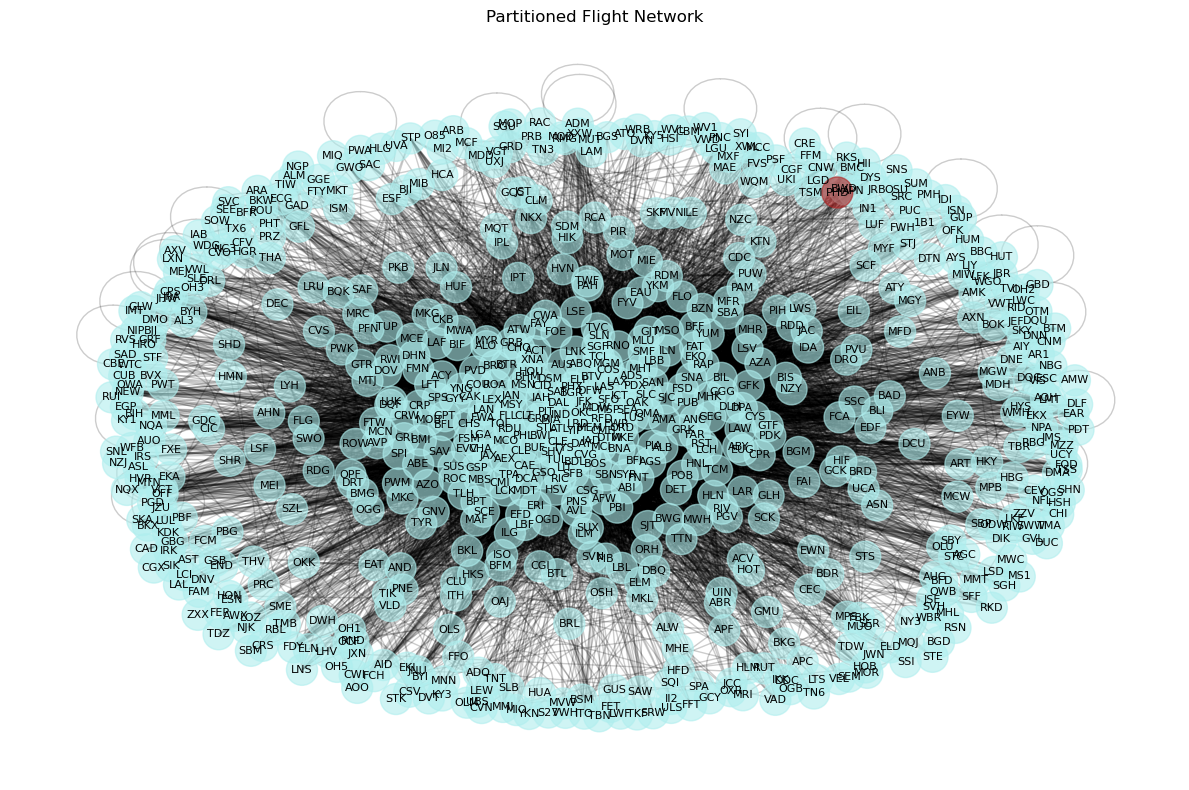

In [ ]:
edges_removed = shortest_path.disconnect_graph(flight_network_undirected)

These graphs and their each disconnection are not very clear, because of the large number of flights. To make it clearer, we are going to solve it with a small sample of flights.

100%|██████████| 14/14 [00:00<00:00, 121826.26it/s]

Visualizing original network...


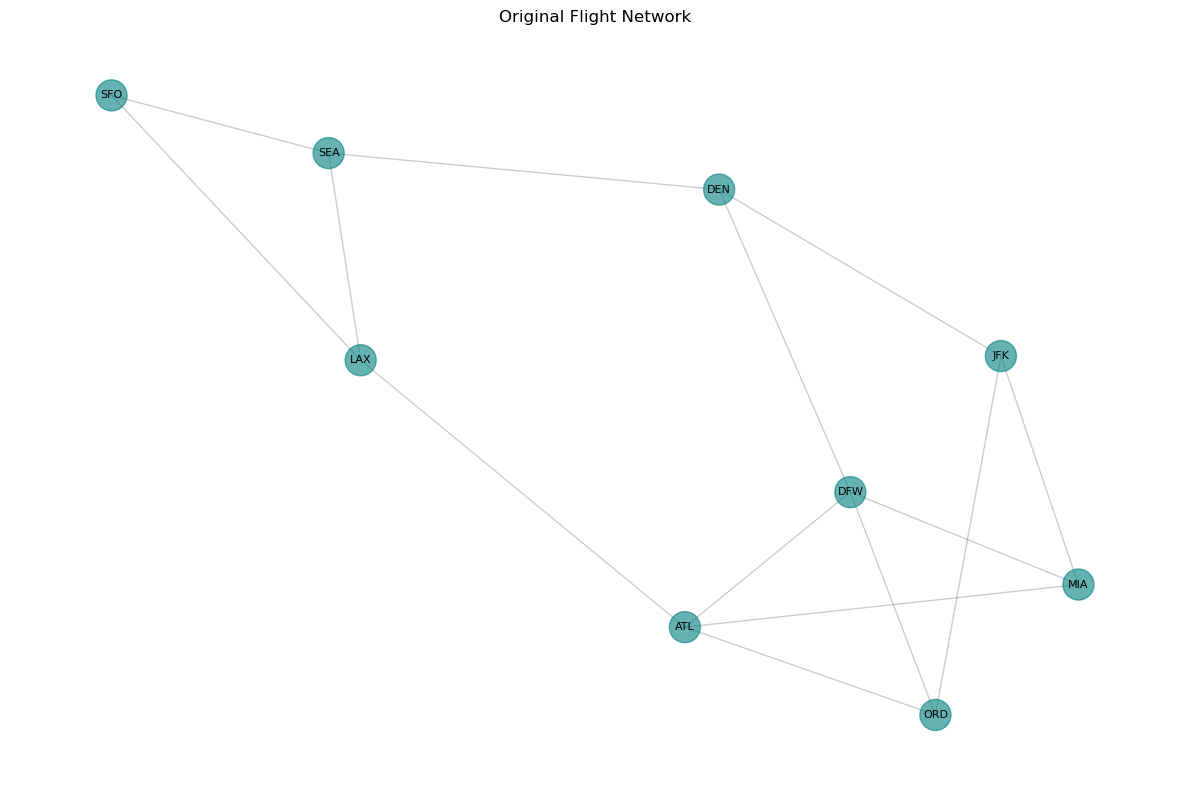

Finding minimum cut...

Minimum number of flights to remove: 2

Flights to remove:
LAX <-> SFO
SFO <-> SEA

Visualizing partitioned network...


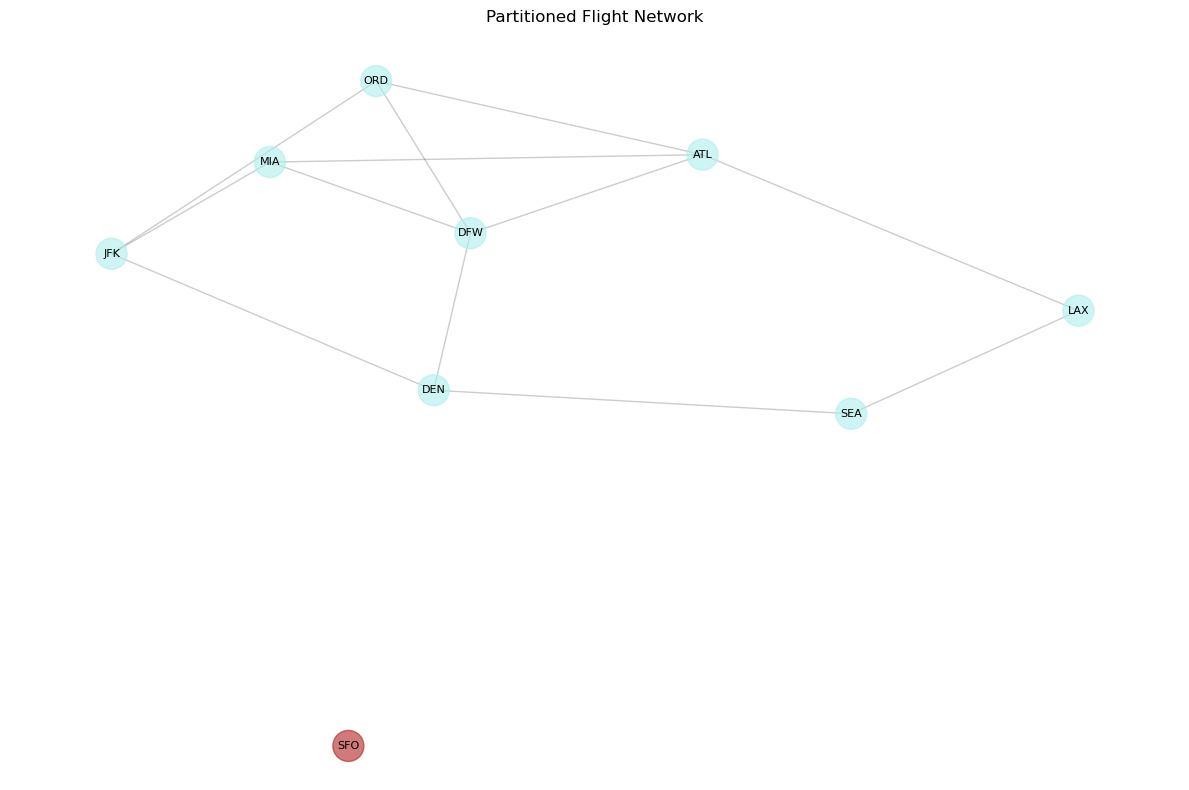

Flights Removed: LAX <-> SFO
Flights Removed: SFO <-> SEA


In [ ]:
import networkx as nx
# Create a graph with at least 10 nodes and multiple edges
G = nx.Graph()
edges = [
    ("ATL", "LAX"),
    ("ATL", "ORD"),
    ("ATL", "DFW"),
    ("LAX", "SFO"),
    ("LAX", "SEA"),
    ("ORD", "DFW"),
    ("ORD", "JFK"),
    ("DFW", "DEN"),
    ("DFW", "MIA"),
    ("SFO", "SEA"),
    ("SEA", "DEN"),
    ("DEN", "JFK"),
    ("JFK", "MIA"),
    ("MIA", "ATL")
]

# Add edges to the graph
G.add_edges_from(edges)

# Create a DataFrame from the edges
dummy_df = pd.DataFrame(edges, columns=["Origin_airport", "Destination_airport"])

dummy_flight_network = shortest_path.create_undirected_flight_network(dummy_df)

# run the algorithm

edges_removed = shortest_path.disconnect_graph(dummy_flight_network)
for u, v in edges_removed:
    print(f"Flights Removed: {u} <-> {v}")

As can be seen from the plots, the the graph is correctly disconncted by using the min number of edges!

----

# Q5

**IMPORT LIBRARIES**

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**READING CSV FILE**

In [ ]:
data = pd.read_csv('drive/MyDrive/Airports2.csv')

# Display the data
print(data.columns)

Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_date', 'Origin_population', 'Destination_population',
       'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat',
       'Dest_airport_long'],
      dtype='object')


**GRAPH CREATION**

In [ ]:
import networkx as nx
df = data.copy()

# Step 2: Initialize a directed graph
G = nx.DiGraph()
i=0
# Step 3: Add nodes and edges from the DataFrame
for _, row in df.iterrows():

    # Add Origin and Destination airports as nodes
    G.add_node(
        row['Origin_city'],



    )
    '''  origin_city=row['Origin_city'],
        origin_airport=row['Origin_airport'],
        population=row['Origin_population'],
        latitude=row['Org_airport_lat'],
        longitude=row['Org_airport_long'] '''
    G.add_node(
        row['Destination_city'],



    )
    '''   destination_airport=row['Destination_airport'],
        destination_city=row['Destination_city'],
        population=row['Destination_population'],
        latitude=row['Dest_airport_lat'],
        longitude=row['Dest_airport_long'] '''

    # Add the flight information as an edge between Origin and Destination
    G.add_edge(
        row['Origin_city'],

        row['Destination_city'],
        distance=row['Distance'],


    )

    ''' fly_date=row['Fly_date'],
        passengers=row['Passengers'],
        seats=row['Seats'],
        flights=row['Flights'], '''
    '''  '''



''' # Step 4: Print the graph's nodes and edges to verify
print("Nodes and their attributes:")
for node, attributes in G.nodes(data=True):
    print(node, attributes)

print("\nEdges and their attributes:")
for u, v, attributes in G.edges(data=True):
    print(f"{u} -> {v}:", attributes) '''

' # Step 4: Print the graph\'s nodes and edges to verify\nprint("Nodes and their attributes:")\nfor node, attributes in G.nodes(data=True):\n    print(node, attributes)\n\nprint("\nEdges and their attributes:")\nfor u, v, attributes in G.edges(data=True):\n    print(f"{u} -> {v}:", attributes) '

**LOUVAIN ALGORITHM IMPLEMENTATION**

In [ ]:
def compute_modularity(graph, partition):
    """
    Calculate modularity of the graph for a given partition.

    Parameters:
    - graph: NetworkX graph
    - partition: Dictionary of node to community mappings

    Returns:
    - Modularity score
    """
    m = graph.size(weight="distance")  # Total edge weight
    degrees = {node: sum(data["distance"] for _, _, data in graph.edges(node, data=True)) for node in graph.nodes()}

    modularity = 0
    for community in set(partition.values()):
        community_nodes = [node for node, comm in partition.items() if comm == community]
        internal_edges = graph.subgraph(community_nodes).size(weight="weight")
        degree_sum = sum(degrees[node] for node in community_nodes)
        modularity += (internal_edges / m) - (degree_sum / (2 * m))**2

    return modularity

def louvain_method_check(graph):
    """
    Louvain method for community detection.

    Parameters:
    - graph: NetworkX graph object

    Returns:
    - Dictionary mapping each node to its community
    """
    # Step 1: Initialize each node in its own community
    partition = {node: node for node in graph.nodes()}
    modularity = compute_modularity(graph, partition)
    previous_modularity=modularity
    max_modularity=modularity
    starter=0
    checker=0
    print(f"Initial modularity: {modularity:.4f}")
    earlier_partition=partition
    # Step 2: Iteratively improve the partition
    while True:
        moved = False  # Track if any node has moved
        print(len(graph.nodes()))
        i=0
        for node in graph.nodes():
            print("This is node number:",i)
            i+=1
            # Compute the modularity gain for moving `node` to each neighbor's community
            current_community = partition[node]
            best_community = current_community
            max_modularity_gain = 0
            neighbors = list(graph.neighbors(node))
            sorted_neighbors = sorted(
        neighbors,
        key=lambda n: graph[node][n].get('weight', 1)  # Default weight=1 if not provided
    )
            # Compute modularity gain for neighboring communities
            for neighbor in graph.neighbors(node):
                neighbor_community = partition[neighbor]
                if neighbor_community == current_community:
                    continue

                # Temporarily move the node to the neighbor's community
                partition[node]=neighbor_community
                new_modularity = compute_modularity(graph, partition)
                modularity_gain = new_modularity - modularity

                # Keep the move if it improves modularity
                if modularity_gain > max_modularity_gain:
                    max_modularity_gain = modularity_gain
                    best_community = neighbor_community

            # Assign the node to the best community found
            if best_community != current_community:
                moved = True
                partition[node] = best_community


        # Update modularity
        new_modularity = compute_modularity(graph, partition)
        print(f"Modularity after pass: {new_modularity:.4f}")
        print(f"Modularity before pass: {modularity:.4f}")
        print("Are we here inside for checking our values????")
        if new_modularity==previous_modularity:
          starter+=1
          return earlier_partition
        if not moved or new_modularity <= modularity:
            checker+=1
            return earlier_partition
              # Stop if no improvement
        if new_modularity>max_modularity:
          max_modularity=new_modularity
          earlier_partition=partition
        previous_modularity=new_modularity




    return partition
communities=louvain_method_check(G)

Initial modularity: -0.0014
563
This is node number: 0
This is node number: 1
This is node number: 2
This is node number: 3
This is node number: 4
This is node number: 5
This is node number: 6
This is node number: 7
This is node number: 8
This is node number: 9
This is node number: 10
This is node number: 11
This is node number: 12
This is node number: 13
This is node number: 14
This is node number: 15
This is node number: 16
This is node number: 17
This is node number: 18
This is node number: 19
This is node number: 20
This is node number: 21
This is node number: 22
This is node number: 23
This is node number: 24
This is node number: 25
This is node number: 26
This is node number: 27
This is node number: 28
This is node number: 29
This is node number: 30
This is node number: 31
This is node number: 32
This is node number: 33
This is node number: 34
This is node number: 35
This is node number: 36
This is node number: 37
This is node number: 38
This is node number: 39
This is node numbe

In [ ]:
from cdlib import NodeClustering
communities_list = []
for community_id in set(communities.values()):
    community_nodes = [node for node, comm_id in communities.items() if comm_id == community_id]
    communities_list.append(community_nodes)
print(len(communities_list))
# Now use communities_list in NodeClustering
community_structure = NodeClustering(communities=communities_list, graph=G, method_name="Custom")
#community_structure = NodeClustering(communities=communities, graph=G, method_name="Custom")

# Calculate modularity
modularity_score = community_structure.newman_girvan_modularity().score

# Display the modularity score
print("Modularity score:", modularity_score)

61
Modularity score: -0.14044406464878686


In [ ]:
print(communities_list)
print(len(communities_list))

[['Farmington, MO'], ['Detroit, MI', 'Marion, OH', 'Peru, IN', 'Rome, GA', 'Springfield, OH', 'Sterling, IL', 'Grenada, MS', 'Bedford, IN', 'Freeport, IL', 'Sikeston, MO', 'Sedalia, MO', 'Danville, IL', 'Pine Bluff, AR', 'Chillicothe, OH', 'Athens, OH', 'Ottumwa, IA', 'New Philadelphia, OH'], ['Muscatine, IA'], ['Alamogordo, NM'], ['Richmond, KY'], ['San Francisco, CA', 'Crescent City, CA', 'Meridian, MS', 'Ukiah, CA', 'Bishop, CA', 'Brookings, OR'], ['Kalamazoo, MI', 'Ithaca, NY', 'Binghamton, NY'], ['Columbus, NE'], ['Manhattan, KS', 'Ames, IA', 'Pittsfield, MA'], ['Port Angeles, WA', 'Walla Walla, WA', 'Oak Harbor, WA', 'Bremerton, WA'], ['Fort Smith, AR', 'Kansas City, MO', 'St. Louis, MO', 'Madisonville, KY', 'Great Bend, KS', 'Burlington, IA', 'Morristown, TN', 'Kirksville, MO', 'Miami, OK', 'Athens, TN', 'Dalton, GA', 'Sturgis, MI', 'Zanesville, OH', 'Mount Pleasant, MI', 'Elizabethtown, KY', 'Americus, GA', 'Bellefontaine, OH', 'Greeneville, TN', 'Lawrenceburg, TN', 'Sebastian,

**Finding and extracting communities**

In [ ]:
import matplotlib.pyplot as plt
def find_and_extract_communities(G,city1,city2,communities_list):

  print(len(communities_list))
  G = nx.Graph()
  print(type(communities.values()))
  final_result=[]

  for element in communities.keys():
    final_result.append(communities[element])
  # Add nodes and edges for each community
  for i, community in enumerate(final_result):
      G.add_nodes_from(community, community_id=i)  # Add nodes with a community attribute
      for node1 in community:
          for node2 in community:
              if node1 != node2:  # Connect all nodes in the same community
                  G.add_edge(node1, node2)

  inside_same_community=False
  for lister in final_result:
    if city1 in lister and city2 in lister:
      inside_same_community=True
      break
  # Generate positions for nodes
  pos = nx.spring_layout(G, seed=42)

  # Assign colors for communities

  color_palette = plt.cm.tab20.colors
  node_colors = [color_palette[data['community_id'] % len(color_palette)] for _, data in G.nodes(data=True)]

  # Plot the graph
  plt.figure(figsize=(12, 12))
  nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.9)
  nx.draw_networkx_edges(G, pos, alpha=0.5)
  nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

  # Add community size annotation

  for i, community in enumerate(final_result):

      # Compute the center of each community for annotation
      community_pos = [pos[node] for node in community]
      x_coords, y_coords = zip(*community_pos)
      plt.text(
          sum(x_coords) / len(x_coords), sum(y_coords) / len(y_coords),  # Center of the community
          f"Size: {len(community)}",  # Annotate with the size
          fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.6)
      )

  # Title and display
  plt.title("Graph Visualization of ")
  plt.show()
  print(len(communities_list),inside_same_community)
  return len(communities_list),inside_same_community

61
<class 'dict_values'>


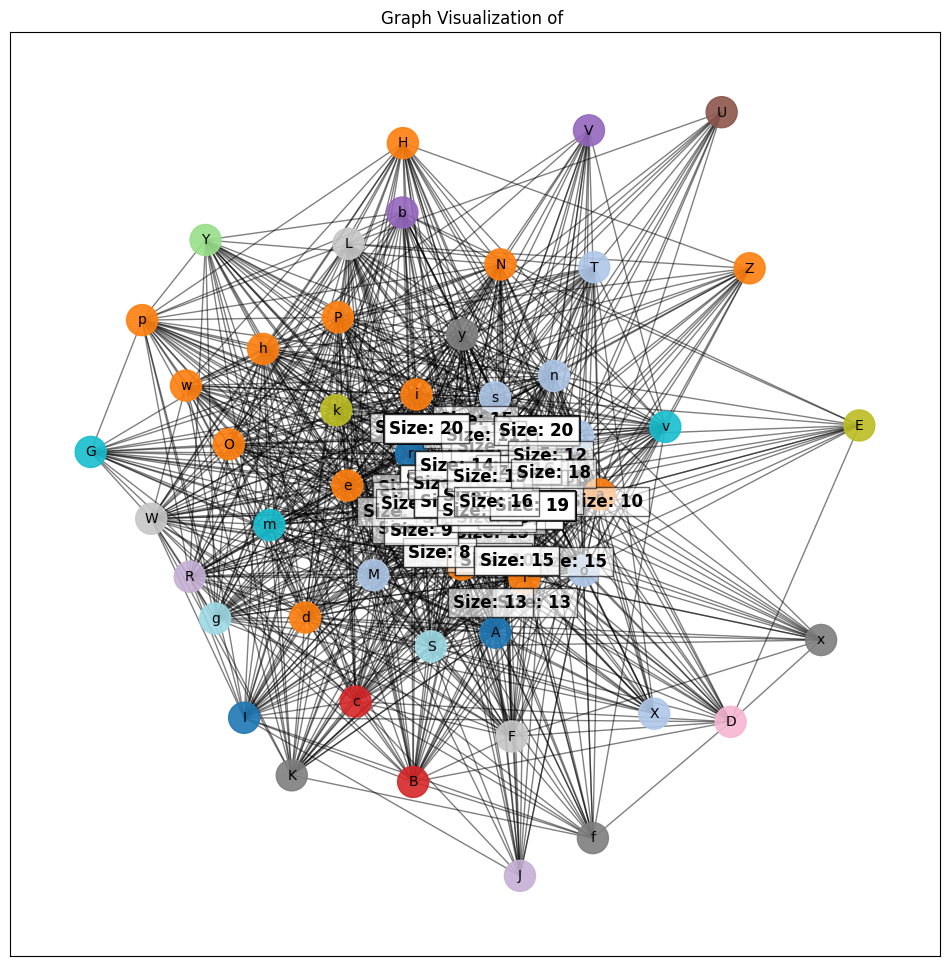

61 False
(61, False)


In [ ]:
print(find_and_extract_communities(G,"Manhattan, KS","Ames, IA",communities_list))

**Alternative algorithm label propagation**

In [ ]:
from collections import Counter
def custom_label_propagation(G, min_community_size=110, max_iterations=400):

    # Initialize each node with a unique label
    labels = {node: node for node in G.nodes()}
    iteration = 0
    converged = False

    while not converged and iteration < max_iterations:
        converged = True
        nodes = list(G.nodes())
        np.random.shuffle(nodes)

        for node in nodes:
            # Collect labels of neighbors
            neighbor_labels = [labels[neighbor] for neighbor in G.neighbors(node)]
            if neighbor_labels:
                # Update label to the most common neighbor label
                most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
                if labels[node] != most_common_label:
                    labels[node] = most_common_label
                    converged = False

        # Ensure minimum community size constraint
        label_counts = Counter(labels.values())
        for node in labels:
            if label_counts[labels[node]] < min_community_size:
                # Reassign to a larger community
                neighbor_labels = [labels[neighbor] for neighbor in G.neighbors(node)]
                if neighbor_labels:
                    labels[node] = Counter(neighbor_labels).most_common(1)[0][0]

        iteration += 1

    # Group nodes into communities based on labels
    communities = {}
    for node, label in labels.items():
        communities.setdefault(label, []).append(node)

    return list(communities.values())

def plot_communities(graph, communities, title):

    color_map = {}
    for i, community in enumerate(communities):
        for node in community:
            color_map[node] = i
    colors = [color_map[node] for node in graph.nodes()]
    nx.draw(graph, node_color=colors, with_labels=True, cmap=plt.cm.rainbow)
    plt.title(title)
    plt.show()

In [ ]:
from cdlib import NodeClustering
communities_list=custom_label_propagation(G)


# Now use communities_list in NodeClustering
community_structure = NodeClustering(communities=communities_list, graph=G, method_name="Custom")
#community_structure = NodeClustering(communities=communities, graph=G, method_name="Custom")

# Calculate modularity
modularity_score = community_structure.newman_girvan_modularity().score

# Display the modularity score
print("Modularity score:", modularity_score)


Modularity score: -0.4954670337185211


The custom **label propagation algorithm** outperforms the Louvain algorithm in terms of computational performance, typically being faster and more efficient when handling large-scale networks. This efficiency makes it a compelling choice in scenarios where quick execution is crucial, such as real-time analysis or iterative updates in dynamic graphs. However, despite its performance benefits, the modularity score achieved by the custom label propagation algorithm is generally lower than that of the Louvain algorithm.

This lower modularity score indicates that the quality of the detected communities—based on the strength of connections within communities relative to connections between them—is somewhat inferior compared to the results of the Louvain method. The Louvain algorithm is known for its robust modularity optimization, which often yields communities that are more cohesive and better defined, albeit at the cost of higher computational demand.

In summary, while the custom label **propagation algorithm** is advantageous for speed and scalability, it may compromise the quality of community detection as measured by modularity. The choice between the two algorithms depends on the specific requirements of the task, such as whether computational efficiency or community quality is the primary objective.

# Algorithmic Question

function findCheapestRoute(n, flights, src, dst, k):
    // Step 1: Initialize graph as an adjacency list
    graph = initializeGraph(n, flights) // adjacency list of flights
    
    // Step 2: Create a priority queue to process cities in order of cost
    priorityQueue = empty priority queue
    priorityQueue.push((0, src, 0)) // (cost, city, stops)
    
    // Step 3: Initialize distance array to store the minimum cost for each city and number of stops
    dist = initializeDistanceArray(n, k)
    dist[src][0] = 0  // No cost to start at the source city with 0 stops

    // Step 4: Process the cities in the priority queue
    while priorityQueue is not empty:
        currentCost, currentCity, currentStops = priorityQueue.pop()

        // Step 5: If we've reached the destination city with <= k stops, return the cost
        if currentCity == dst:
            return currentCost

        // Step 6: If we have exceeded k stops, continue processing other cities
        if currentStops > k:
            continue

        // Step 7: Explore all neighboring cities that are reachable from the current city
        for each neighbor in graph[currentCity]:
            nextCity = neighbor[0]
            flightCost = neighbor[1]
            newCost = currentCost + flightCost

            // Step 8: If traveling to the next city is cheaper with the current number of stops, update and push to the queue
            if newCost < dist[nextCity][currentStops + 1]:
                dist[nextCity][currentStops + 1] = newCost
                priorityQueue.push((newCost, nextCity, currentStops + 1))

    // Step 9: If no valid path exists, return -1
    return -1


In [ ]:
import heapq

def findCheapestRoute(n, flights, src, dst, k):
    # Initialize adjacency list for the flights
    graph = {i: [] for i in range(n)}
    for u, v, cost in flights:
        graph[u].append((v, cost))

    # Initialize dist array, each element holds a list of distances for 0 to k stops
    dist = [[float('inf')] * (k + 2) for _ in range(n)]
    dist[src][0] = 0  # No cost to start at the source with 0 stops

    # Min-heap priority queue: (cost, city, stops)
    pq = [(0, src, 0)]  # Starting at src with 0 stops

    while pq:
        current_cost, current_city, stops = heapq.heappop(pq)

        # If we reached destination with <= k stops, return the cost
        if current_city == dst:
            return current_cost

        # If we've already used k+1 stops, don't continue exploring
        if stops > k:
            continue

        # Explore all neighbors
        for next_city, price in graph[current_city]:
            new_cost = current_cost + price
            # Only consider this new path if it's cheaper and we haven't exceeded stops
            if new_cost < dist[next_city][stops + 1]:
                dist[next_city][stops + 1] = new_cost
                heapq.heappush(pq, (new_cost, next_city, stops + 1))

    # No valid path found with <= k stops
    return -1


In [ ]:
# Example 1
n = 4
flights = [[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]]
src = 0
dst = 3
k = 1
print(findCheapestRoute(n, flights, src, dst, k))  # Output: 700

# Example 2
n = 3
flights = [[0, 1, 100], [1, 2, 100], [0, 2, 500]]
src = 0
dst = 2
k = 1
print(findCheapestRoute(n, flights, src, dst, k))  # Output: 200

# Example 3
n = 3
flights = [[0, 1, 100], [1, 2, 100], [0, 2, 500]]
src = 0
dst = 2
k = 0
print(findCheapestRoute(n, flights, src, dst, k))  # Output: 500

# Example 4
n = 4
flights = [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 300]]
src = 0
dst = 3
k = 2
print(findCheapestRoute(n, flights, src, dst, k))  # Output: 400

# Example 5
n = 4
flights = [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 200]]
src = 0
dst = 3
k = 2
print(findCheapestRoute(n, flights, src, dst, k))  # Output: 400


700
200
500
400
400


For each state, we process it by checking its neighbors, which can take
𝑂
(
𝐸
)
O(E) time where
𝐸
E is the number of edges. The total number of states is
𝑂
(
𝑛
×
(
𝑘
+
1
)
)
O(n×(k+1)) (each city and each stop count), and for each state, we perform a heap operation that takes
𝑂
(
log
⁡
(
𝑛
×
(
𝑘
+
1
)
)
)
O(log(n×(k+1))).

Thus, the overall time complexity is:

𝑂
(
𝐸
⋅
log
⁡
(
𝑛
×
(
𝑘
+
1
)))
O(E⋅log(n×(k+1)))


Efficiency for Large Graphs:
For large graphs where
𝑛
>
100
n>100, the algorithm should be efficient enough for moderate values of
𝑘
k. However, as
𝑘
k increases, the space and time complexity grow significantly. If
𝑘
k is very large (e.g., close to
𝑛
n), the algorithm might become slower. Optimizing for very large
𝑛
n and
𝑘
k would involve reducing redundant states or using more advanced graph traversal techniques

function optimizedFindCheapestRoute(n, flights, src, dst, k):
    graph = initializeGraph(n, flights)
    pq = priority queue
    pq.push((0, src, 0))
    
    dist = [infinity] * n
    dist[src] = 0
    
    for stops from 0 to k:
        newDist = dist for this stop level
        while pq is not empty:
            currentCost, currentCity, currentStops = pq.pop()
            for each neighbor in graph[currentCity]:
                nextCity, price = neighbor
                newCost = currentCost + price
                if newCost < newDist[nextCity]:
                    newDist[nextCity] = newCost
                    pq.push((newCost, nextCity, currentStops + 1))
        dist = newDist
    
    return dist[dst] if dist[dst] != infinity else -1
\\

Time Complexity: The time complexity remains the same as the original algorithm,
𝑂
(
𝐸
log
⁡
(
𝑛
×
(
𝑘
+
1
)
)
)
O(Elog(n×(k+1))), but with reduced memory usage.

Space Complexity: The space complexity is reduced to
𝑂
(
𝑛
)
O(n), as we only store one state per city instead of multiple states for each number of stop

If we were to ask an LLM (e.g., ChatGPT) for an optimized version, it might suggest similar improvements, such as limiting the number of states stored or using a different graph traversal algorithm, like A search*, to focus on promising paths early on.

Comparison:

Performance: Both versions may exhibit similar performance for large graphs with modest
𝑘
k, but the LLM might provide insights on more advanced heuristics.
Time Complexity: The time complexity is likely to remain
𝑂
(
𝐸
log
⁡
(
𝑛
×
(
𝑘
+
1
)
)
)
O(Elog(n×(k+1))) for both versions.
Correctness: Both versions should be correct if implemented according to the problem constraints.